In [ ]:
import numpy as np
from PIL import Image
from google.colab import drive
drive.mount('/content/drive')
import matplotlib.pyplot as plt
import math
import cv2
import torch
import pandas as pd
from torchvision import transforms
from torchvision.transforms import Compose, ToTensor
import torchvision.models as models

Mounted at /content/drive


In [ ]:
import os
import zipfile
local_zip = '/content/drive/MyDrive/Colab Notebooks/Image_Processing_2025_1/Animals.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/dataset')
zip_ref.close()

In [ ]:
# 히스토그램 계산 함수--오츄 알고리즘에 사용
def make_histogram(image, N):
  histogram = np.zeros(N)
  for i in range(image.shape[0]):
    for j in range(image.shape[1]):
      histogram[image[i][j]] += 1
  return histogram

# 임계값 기준으로 이진화 진행 함수--오츄 알고리즘 함수에 사용
def make_binary_img(img, T):
  binary_image = img.copy()

  binary_image[img>=T]=1
  binary_image[img<T]=0

  return binary_image

def otsu_function(image):
  hist = make_histogram(image, 256)  # Calculate the histogram
  total_pixels = image.shape[0] * image.shape[1]
  current_max_variance = 0
  optimal_threshold = 0

  for threshold in range(1, 256):
    # Calculate the number of pixels in each class
    foreground_pixels = sum(hist[:threshold])
    background_pixels = total_pixels - foreground_pixels

    if foreground_pixels == 0 or background_pixels == 0:
      continue

    # Calculate the mean of each class
    foreground_mean = sum([i * hist[i] for i in range(threshold)]) / foreground_pixels
    background_mean = sum([i * hist[i] for i in range(threshold, 256)]) / background_pixels

    # Calculate the between-class variance
    variance = (foreground_pixels / total_pixels) * (background_pixels / total_pixels) * (foreground_mean - background_mean) ** 2

    if variance > current_max_variance:
      current_max_variance = variance
      optimal_threshold = threshold

  binary_image = make_binary_img(image, optimal_threshold)
  return binary_image


In [ ]:
class CustomDataset(torch.utils.data.Dataset): ## make custom dataset
  def __init__(self, annotation_path ,root_dir = '/dataset'): # root_dir : The parent directory path of the train and test directories.
        'Initialization'

        self.data_annotation = pd.read_csv(os.path.join(annotation_path))
        self.data_path = self.data_annotation['filepath']
        self.labels = self.data_annotation['label']
        self.root_dir = root_dir
        self.transforms = Compose([
            ToTensor()
        ])

  def __len__(self):
        'Denotes the total number of samples'
        return len(self.data_path)

  def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        file_path = os.path.join(self.root_dir,self.data_path[index])
        input_image = cv2.cvtColor( cv2.imread(file_path), cv2.COLOR_BGR2RGB)
        input_image = self._preprocessing(input_image)

        pil_image_for_transform = Image.fromarray(input_image) # cv --> PIL for transform
        X = self.transforms(pil_image_for_transform) ## data preprocessing
        # Load data and get label
        y = torch.tensor(self.labels[index]).long()
        return X, y
  # 이미지를 읽자마자 수행하는 작업
  # 1) grayscale이미지-->히스토그램 평활화
  # 2) 64로 리사이즈
  # 3) 리사이즈 이미지에서 소벨필터로 에지 검출
  # 4) 에지 이미지에서 임계값을 통해 이진화 진행
  def _preprocessing(self, image_c):
        gray_img = cv2.cvtColor(image_c, cv2.COLOR_RGB2GRAY) # grayscale로 이미지 읽기
        hist_img = cv2.equalizeHist(gray_img) # 히스토그램 평황화 진행
        resize_img = cv2.resize(hist_img, (64,64), interpolation=cv2.INTER_AREA)
        # 리사이즈 이미지에서 에지 검출

        sobel_x = cv2.Sobel(resize_img, cv2.CV_64F,1,0,3) # sobel(이미지,x,y,k_size)
        sobel_y = cv2.Sobel(resize_img, cv2.CV_64F,0,1,3)
        sobel_combined = np.sqrt(sobel_x**2 + sobel_y**2)
        sobel_final = np.uint8(np.absolute(sobel_combined))
        binary_img = make_binary_img(sobel_final, 100) # 임계값 기준 이진화

        #canny_img = cv2.Canny(resize_img, 30, 225) # Canny edge detection
        #binary_img = otsu_function(canny_img) # 리사이즈 이미지 이진화
        return binary_img.astype(np.uint8)

total training images: 8000
total test images: 788
Torch size: torch.Size([1, 64, 64])
오츄 이진화 + canny 에지


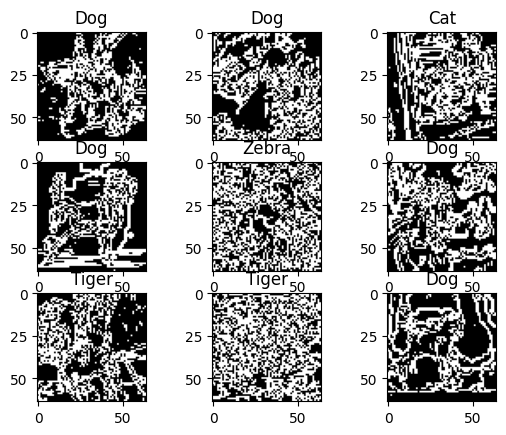

In [ ]:
import random

## make by using custom dataset class
trainset = CustomDataset(annotation_path = '/dataset/train_annotation.csv')
testset = CustomDataset(annotation_path = '/dataset/test_annotation.csv')

print('total training images:', len(trainset))
print('total test images:', len(testset))
print('Torch size:', trainset[0][0].shape)
print('오츄 이진화 + canny 에지')

## visualize
class_names=['Cat','Dog','Tiger','Zebra']
for i in range(9):
  random_index = random.randint(0,8000)
  image, label = trainset[random_index]
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image.permute(1,2,0).numpy(),cmap='gray')
  plt.title(class_names[int(label)])
  #plt.axis("off")

In [ ]:
# prompt: 훈련용 데이터셋에서 400장 테스트 데이터 셋에서 100장을 랜덤으로 추출하여 custumdataset 클래스를 활용해서 데이터 셋으로 형성

# Select random samples
train_indices = random.sample(range(len(trainset)),1000)
test_indices = random.sample(range(len(testset)),100)

# Create subsets using the selected indices
train_subset = torch.utils.data.Subset(trainset, train_indices)
test_subset = torch.utils.data.Subset(testset, test_indices)

print(f'Number of images in the training subset: {len(train_subset)}')
print(f'Number of images in the test subset: {len(test_subset)}')

Number of images in the training subset: 1000
Number of images in the test subset: 100


In [ ]:
## make model and using GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('device: ', device)

device:  cuda


In [ ]:
import multiprocessing

num_cpus = multiprocessing.cpu_count()
print(f"Number of available CPUs: {num_cpus}")


Number of available CPUs: 2


In [ ]:
!pip install torchinfo -qq

In [ ]:
from torchsummary import summary

In [ ]:
# 수정된 BasicLeNet
import torch.nn as nn
class LeNetCustom(nn.Module):
    def __init__(self):
        super(LeNetCustom, self).__init__()
      # Block 1
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)  # 채널 감소
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)  # 스트라이드 2
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()
        self.shortcut = nn.Conv2d(32, 64, kernel_size=1, stride=2, padding=0)  # 잔차 연결
        # Block 2
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU()
        # Global Average Pooling
        self.gap = nn.AdaptiveAvgPool2d(1)  # 128x16x16 -> 128x1x1
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(128, 4)  # 4개 클래스, FC 레이어 간소화
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        # Block 1
        x1 = self.relu1(self.bn1(self.conv1(x)))  # 32x64x64
        shortcut = self.shortcut(x1)  # 64x32x32
        x2 = self.relu2(self.bn2(self.conv2(x1)))  # 64x32x32
        x2 = x2 + shortcut  # 잔차 연결
        # Block 2
        x3 = self.relu3(self.bn3(self.conv3(x2)))  # 128x16x16
        # Global Average Pooling
        x = self.gap(x3)  # 128x1x1
        x = self.flatten(x)
        x = self.dropout(x)
        x = self.fc(x)
        return x

model1 = LeNetCustom().to(device)
summary(model1,(1,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             320
       BatchNorm2d-2           [-1, 32, 64, 64]              64
              ReLU-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 64, 32, 32]           2,112
            Conv2d-5           [-1, 64, 32, 32]          18,496
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8          [-1, 128, 16, 16]          73,856
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
AdaptiveAvgPool2d-11            [-1, 128, 1, 1]               0
          Flatten-12                  [-1, 128]               0
          Dropout-13                  [-1, 128]               0
           Linear-14                   

In [ ]:
class AlexNetCustum(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=2, padding=2), # 96→32, 11→5
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),          # 192→64, 5→3
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),          # 256→64
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            # Fully connected 파라미터 대폭 감소
            # 마지막 feature map을 1x1로 줄임
            nn.AdaptiveAvgPool2d((1,1))
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32*1*1, 8),
            nn.ReLU(inplace=True),
            nn.Linear(8, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model2 = AlexNetCustum(num_classes=4).to(device)
summary(model2,(1,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             832
              ReLU-2           [-1, 32, 32, 32]               0
         MaxPool2d-3           [-1, 32, 16, 16]               0
            Conv2d-4           [-1, 64, 16, 16]          18,496
              ReLU-5           [-1, 64, 16, 16]               0
            Conv2d-6           [-1, 32, 16, 16]          18,464
              ReLU-7           [-1, 32, 16, 16]               0
         MaxPool2d-8             [-1, 32, 8, 8]               0
 AdaptiveAvgPool2d-9             [-1, 32, 1, 1]               0
          Flatten-10                   [-1, 32]               0
           Linear-11                    [-1, 8]             264
             ReLU-12                    [-1, 8]               0
           Linear-13                    [-1, 4]              36
Total params: 38,092
Trainable params: 

In [ ]:
class VGGCustom(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(8, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.MaxPool2d(2),
            nn.AdaptiveAvgPool2d((1, 1)),  # Global Average Pooling 추가
        )
        self.classifier = nn.Sequential(
            nn.Linear(32, num_classes)
        )
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)

        return x

model3 = VGGCustom(num_classes=4).to(device)
summary(model3,(1,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 64, 64]              80
              ReLU-2            [-1, 8, 64, 64]               0
         MaxPool2d-3            [-1, 8, 32, 32]               0
            Conv2d-4           [-1, 16, 32, 32]           1,168
              ReLU-5           [-1, 16, 32, 32]               0
         MaxPool2d-6           [-1, 16, 16, 16]               0
            Conv2d-7           [-1, 32, 16, 16]           4,640
              ReLU-8           [-1, 32, 16, 16]               0
         MaxPool2d-9             [-1, 32, 8, 8]               0
        MaxPool2d-10             [-1, 32, 4, 4]               0
AdaptiveAvgPool2d-11             [-1, 32, 1, 1]               0
           Linear-12                    [-1, 4]             132
Total params: 6,020
Trainable params: 6,020
Non-trainable params: 0
-----------------------------------

In [ ]:
## parameters
epoch = 50
batchsize = 64

## dataloader
train_loader = torch.utils.data.DataLoader(trainset,
                                          batch_size=batchsize,
                                          shuffle=True,
                                          num_workers=2,
                                          drop_last=True)

test_loader = torch.utils.data.DataLoader(testset,
                                          batch_size=1,
                                          shuffle=True,
                                          num_workers=2,
                                          drop_last=True)

## loss function
criterion = torch.nn.CrossEntropyLoss() # Cross Entropy

## optimizer setting
optimizer1 = torch.optim.Adam(model1.parameters(), ## Adam optimizer
                            lr=0.01)
lr1  = torch.optim.lr_scheduler.StepLR(optimizer1, step_size=5, gamma=0.5)  # 10에폭마다 lr 0.5배

optimizer2 = torch.optim.Adam(model2.parameters(), ## Adam optimizer
                            lr=0.01)
lr2  = torch.optim.lr_scheduler.StepLR(optimizer2, step_size=5, gamma=0.5)  # 10에폭마다 lr 0.5배

optimizer3 = torch.optim.Adam(model3.parameters(), ## Adam optimizer
                            lr=0.01)
lr3  = torch.optim.lr_scheduler.StepLR(optimizer3, step_size=5, gamma=0.5)  # 10에폭마다 lr 0.5배

In [ ]:
# model training function
def train(model, optimizer, train_loader, epoch):
  train_loss = []
  train_accuracy = []
  avg_loss = 0
  avg_accuracy = 0
  model.train()

  for i, (X,y) in enumerate(train_loader):
      X,y = X.to(device), y.to(device)

      optimizer.zero_grad()
      predict = model(X)
      loss = criterion(predict, y)
      loss.backward()
      optimizer.step()

      _, predicted_classes = torch.max(predict, 1) # Get the predicted class index
      correct_predictions = (predicted_classes == y).sum().item()
      accuracy = correct_predictions / X.shape[0]

      train_accuracy.append(accuracy)
      train_loss.append(loss.item())

  avg_loss = sum(train_loss) /len(train_loss)
  avg_accuracy = sum(train_accuracy) / len(train_accuracy)

  print(f'epoch {epoch}) train loss : {avg_loss:.4f} / train_accuracy : {avg_accuracy:.4f}')
  return avg_loss, avg_accuracy

In [ ]:
def test(model, test_loader):
    model.eval()
    test_loss = []
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)

            predict = model(X)
            loss = criterion(predict, y)
            test_loss.append(loss.item())

            _, predicted_classes = torch.max(predict, 1)
            correct_predictions += (predicted_classes == y).sum().item()
            total_samples += y.size(0)

    avg_loss = sum(test_loss) / len(test_loss)
    accuracy = correct_predictions / total_samples

    print(f'Test Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.4f}')



In [ ]:
# 1번 모델 훈련--LeNetCustum
train_loss1=[]
train_accuracy1=[]
for i in range(epoch):
  train_loss, train_accuracy = train(model1, optimizer1, train_loader, i)
  train_loss1.append(train_loss)
  train_accuracy1.append(train_accuracy)
  lr1.step()

epoch 0) train loss : 1.2587 / train_accuracy : 0.3994
epoch 1) train loss : 1.2093 / train_accuracy : 0.4390
epoch 2) train loss : 1.1925 / train_accuracy : 0.4474
epoch 3) train loss : 1.1794 / train_accuracy : 0.4655
epoch 4) train loss : 1.1601 / train_accuracy : 0.4783
epoch 5) train loss : 1.1282 / train_accuracy : 0.5026
epoch 6) train loss : 1.1175 / train_accuracy : 0.4970
epoch 7) train loss : 1.0995 / train_accuracy : 0.5179
epoch 8) train loss : 1.0699 / train_accuracy : 0.5294
epoch 9) train loss : 1.0628 / train_accuracy : 0.5375
epoch 10) train loss : 1.0019 / train_accuracy : 0.5803
epoch 11) train loss : 0.9652 / train_accuracy : 0.5960
epoch 12) train loss : 0.9441 / train_accuracy : 0.6000
epoch 13) train loss : 0.9129 / train_accuracy : 0.6104
epoch 14) train loss : 0.8871 / train_accuracy : 0.6335
epoch 15) train loss : 0.8385 / train_accuracy : 0.6554
epoch 16) train loss : 0.8080 / train_accuracy : 0.6681
epoch 17) train loss : 0.8011 / train_accuracy : 0.6705
ep

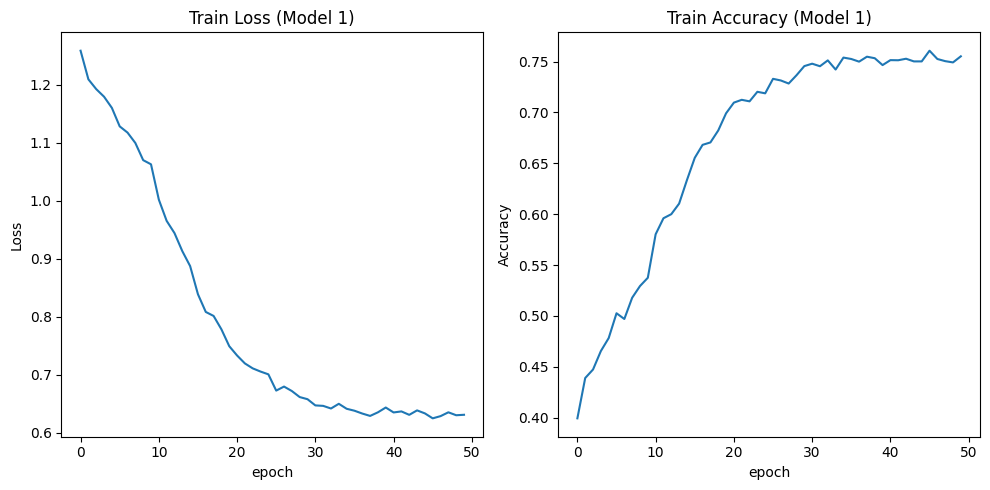

In [ ]:
# model1 loss & accuracy 그래프
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss1)
plt.title('Train Loss (Model 1)')
plt.xlabel('epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accuracy1)
plt.title('Train Accuracy (Model 1)')
plt.xlabel('epoch')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

In [ ]:
# 1번 모델 검증
test(model1,test_loader)


Test Loss: 1.2982, Test Accuracy: 0.4404


In [ ]:
# 2번 모델 훈련--simpleLeNet
train_loss2=[]
train_accuracy2=[]
for i in range(epoch):
  train_loss, train_accuracy = train(model2, optimizer2, train_loader, i)
  train_loss2.append(train_loss)
  train_accuracy2.append(train_accuracy)
  lr1.step()

epoch 0) train loss : 1.3888 / train_accuracy : 0.2526
epoch 1) train loss : 1.3870 / train_accuracy : 0.2482
epoch 2) train loss : 1.3872 / train_accuracy : 0.2446
epoch 3) train loss : 1.3870 / train_accuracy : 0.2435
epoch 4) train loss : 1.3869 / train_accuracy : 0.2506
epoch 5) train loss : 1.3872 / train_accuracy : 0.2424
epoch 6) train loss : 1.3868 / train_accuracy : 0.2506
epoch 7) train loss : 1.3870 / train_accuracy : 0.2447
epoch 8) train loss : 1.3870 / train_accuracy : 0.2459
epoch 9) train loss : 1.3871 / train_accuracy : 0.2502
epoch 10) train loss : 1.3868 / train_accuracy : 0.2466
epoch 11) train loss : 1.3869 / train_accuracy : 0.2445
epoch 12) train loss : 1.3870 / train_accuracy : 0.2475
epoch 13) train loss : 1.3869 / train_accuracy : 0.2506
epoch 14) train loss : 1.3870 / train_accuracy : 0.2450
epoch 15) train loss : 1.3871 / train_accuracy : 0.2454
epoch 16) train loss : 1.3870 / train_accuracy : 0.2480
epoch 17) train loss : 1.3867 / train_accuracy : 0.2457
ep

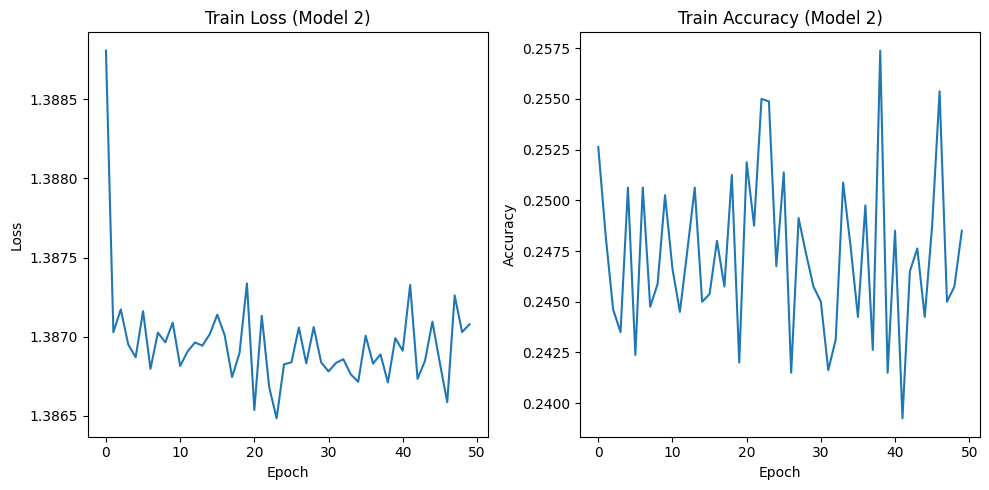

In [ ]:
# model2 loss & accuracy 그래프
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss2)
plt.title('Train Loss (Model 2)')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accuracy2)
plt.title('Train Accuracy (Model 2)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

In [ ]:
# 2번 모델 검증
test(model2,test_loader)

Test Loss: 1.3940, Test Accuracy: 0.1904


In [ ]:
# 3번 모델 훈련--SimpleLeNet
train_loss3=[]
train_accuracy3=[]
for i in range(epoch):
  train_loss, train_accuracy = train(model3, optimizer3, train_loader, i)
  train_loss3.append(train_loss)
  train_accuracy3.append(train_accuracy)
  lr1.step()

epoch 0) train loss : 1.3876 / train_accuracy : 0.2500
epoch 1) train loss : 1.3868 / train_accuracy : 0.2454
epoch 2) train loss : 1.3872 / train_accuracy : 0.2432
epoch 3) train loss : 1.3870 / train_accuracy : 0.2532
epoch 4) train loss : 1.3878 / train_accuracy : 0.2469
epoch 5) train loss : 1.3870 / train_accuracy : 0.2505
epoch 6) train loss : 1.3864 / train_accuracy : 0.2566
epoch 7) train loss : 1.3872 / train_accuracy : 0.2514
epoch 8) train loss : 1.3871 / train_accuracy : 0.2477
epoch 9) train loss : 1.3866 / train_accuracy : 0.2510
epoch 10) train loss : 1.3870 / train_accuracy : 0.2469
epoch 11) train loss : 1.3870 / train_accuracy : 0.2479
epoch 12) train loss : 1.3870 / train_accuracy : 0.2512
epoch 13) train loss : 1.3872 / train_accuracy : 0.2504
epoch 14) train loss : 1.3872 / train_accuracy : 0.2400
epoch 15) train loss : 1.3868 / train_accuracy : 0.2455
epoch 16) train loss : 1.3870 / train_accuracy : 0.2451
epoch 17) train loss : 1.3870 / train_accuracy : 0.2406
ep

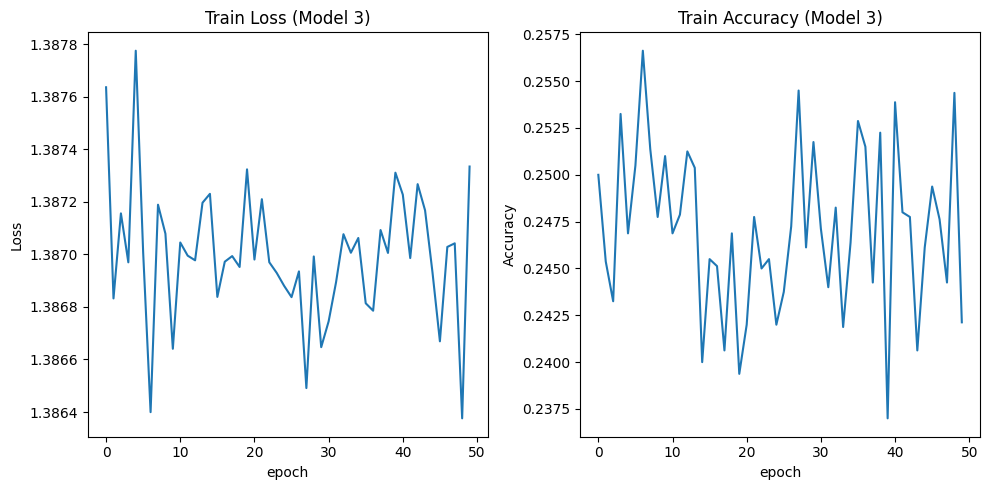

In [ ]:
# model3 loss & accuracy 그래프
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss3)
plt.title('Train Loss (Model 3)')
plt.xlabel('epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accuracy3)
plt.title('Train Accuracy (Model 3)')
plt.xlabel('epoch')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

In [ ]:
# 3번 모델 검증
test(model3,test_loader)

Test Loss: 1.3878, Test Accuracy: 0.1904


In [ ]:
def invert_pixels(image, p):

    image = image.clone()  # 원본 이미지 변경 방지
    total_pixels = image.numel()
    num_pixels_to_invert = int(total_pixels * (p / 100.0))

    # 반전시킬 픽셀의 인덱스를 랜덤으로 선택
    indices_to_invert = random.sample(range(total_pixels), num_pixels_to_invert)

    # 1D 인덱스를 2D (또는 3D) 인덱스로 변환
    # 현재 이미지가 (1, H, W) 형태이므로 1D 인덱스를 2D (H, W) 인덱스로 변환
    h, w = image.shape[1], image.shape[2]
    rows = [idx // w for idx in indices_to_invert]
    cols = [idx % w for idx in indices_to_invert]

    # 선택된 픽셀 값 반전 (0 -> 1, 1 -> 0)
    for r, c in zip(rows, cols):
        image[0, r, c] = 1 - image[0, r, c]

    return image

def create_inverted_dataset(dataset, p):
    inverted_images = []
    labels = []
    for i in range(len(dataset)):
        image, label = dataset[i]
        # Invert p% of pixels
        inverted_image = invert_pixels(image, p)
        inverted_images.append(inverted_image)
        labels.append(label)

    # Stack the list of tensors into a single tensor
    inverted_images_tensor = torch.stack(inverted_images)
    labels_tensor = torch.tensor(labels)

    # Return as a TensorDataset
    class InvertedDataset(torch.utils.data.Dataset):
        def __init__(self, images, labels):
            self.images = images
            self.labels = labels
        def __len__(self):
            return len(self.images)
        def __getitem__(self, idx):
            return self.images[idx], self.labels[idx]
    return InvertedDataset(inverted_images_tensor, labels_tensor)



In [ ]:
# Example usage:
p = 20# % chance of inversion
trainset_inverted = create_inverted_dataset(trainset, p)
testset_inverted = create_inverted_dataset(testset, p)
print(f'Number of images in the inverted training dataset: {len(trainset_inverted)}')
print(f'Number of images in the inverted test dataset: {len(testset_inverted)}')
print('Torch size:', trainset_inverted[0][0].shape)


Number of images in the inverted training dataset: 8000
Number of images in the inverted test dataset: 788
Torch size: torch.Size([1, 64, 64])


In [ ]:
train_loader_inverted = torch.utils.data.DataLoader(trainset_inverted,
                                           batch_size=batchsize,
                                           shuffle=True,
                                           num_workers=2,
                                           drop_last=True)
test_loader_inverted = torch.utils.data.DataLoader(testset_inverted,
                                           batch_size=1,
                                           shuffle=True,
                                           num_workers=2,
                                           drop_last=True)



Visualizing original and inverted train dataset samples:


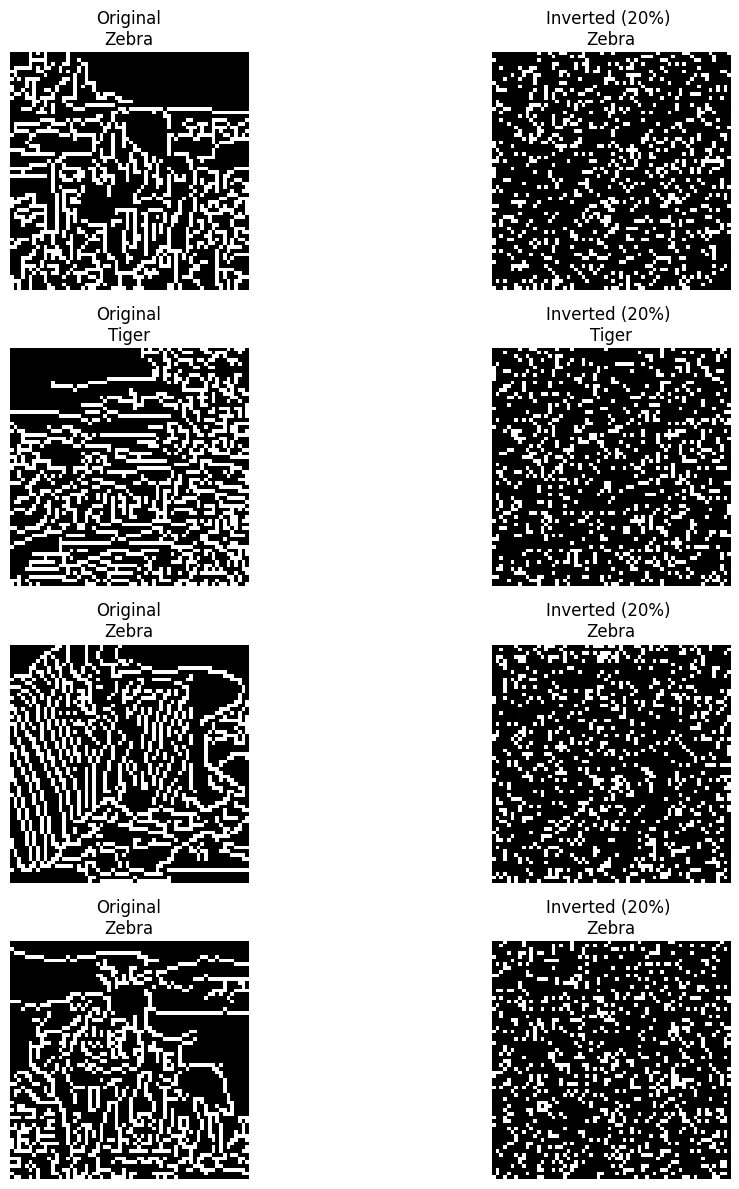

In [ ]:
# prompt: 반전되기 전 이미지와 반전된 이미지를 같이 출력

# Visualize original and inverted images side-by-side
print("\nVisualizing original and inverted train dataset samples:")
class_names = ['Cat','Dog','Tiger','Zebra']
plt.figure(figsize=(12, 12))
for i in range(4): # Display 4 pairs of images
    random_index = random.randint(0, len(trainset) - 1)

    # Get original image
    original_image, original_label = trainset[random_index]

    # Get corresponding inverted image
    inverted_image, inverted_label = trainset_inverted[random_index]

    # Display original image
    ax = plt.subplot(4, 2, 2*i + 1)
    # Permute dimensions for matplotlib (C, H, W) -> (H, W, C) or (H, W) for grayscale
    plt.imshow(original_image.permute(1,2,0).squeeze().numpy(), cmap='gray')
    plt.title(f'Original\n{class_names[int(original_label)]}')
    plt.axis("off")

    # Display inverted image
    ax = plt.subplot(4, 2, 2*i + 2)
    plt.imshow(inverted_image.permute(1,2,0).squeeze().numpy(), cmap='gray')
    plt.title(f'Inverted ({p}%) \n{class_names[int(inverted_label)]}')
    plt.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
# 반전 데이터 1번 모델 훈련 --LeNetCustom
train_loss1=[]
train_accuracy1=[]
for i in range(40):
  train_loss, train_accuracy = train(model1, optimizer1, train_loader_inverted, i)
  train_loss1.append(train_loss)
  train_accuracy1.append(train_accuracy)
  lr1.step()

epoch 0) train loss : 1.4205 / train_accuracy : 0.2571
epoch 1) train loss : 1.3909 / train_accuracy : 0.2572
epoch 2) train loss : 1.3875 / train_accuracy : 0.2627
epoch 3) train loss : 1.3879 / train_accuracy : 0.2535
epoch 4) train loss : 1.3873 / train_accuracy : 0.2575
epoch 5) train loss : 1.3729 / train_accuracy : 0.2883
epoch 6) train loss : 1.3286 / train_accuracy : 0.3444
epoch 7) train loss : 1.3042 / train_accuracy : 0.3649
epoch 8) train loss : 1.2878 / train_accuracy : 0.3840
epoch 9) train loss : 1.2767 / train_accuracy : 0.3874
epoch 10) train loss : 1.2409 / train_accuracy : 0.4283
epoch 11) train loss : 1.2135 / train_accuracy : 0.4415
epoch 12) train loss : 1.1957 / train_accuracy : 0.4505
epoch 13) train loss : 1.1706 / train_accuracy : 0.4694
epoch 14) train loss : 1.1340 / train_accuracy : 0.4923
epoch 15) train loss : 1.0790 / train_accuracy : 0.5312
epoch 16) train loss : 1.0507 / train_accuracy : 0.5414
epoch 17) train loss : 1.0336 / train_accuracy : 0.5504
ep

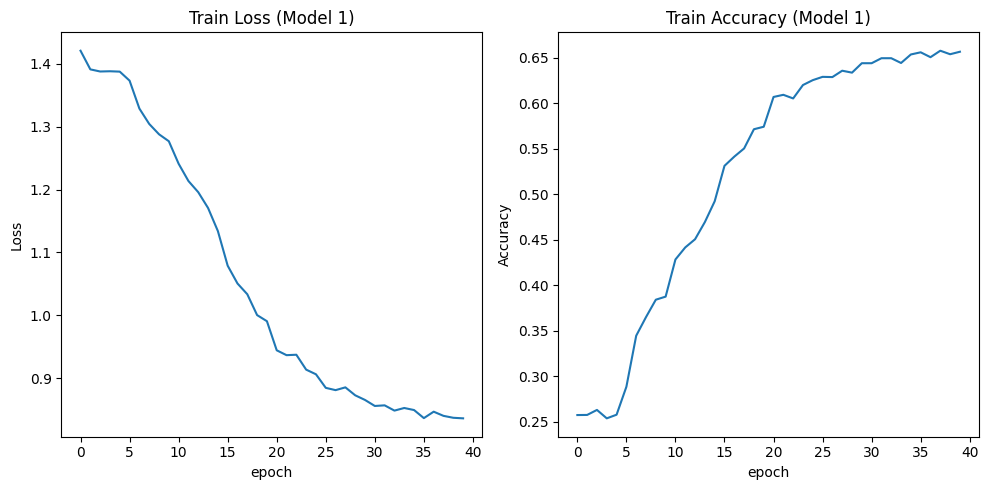

In [ ]:
# model1 loss & accuracy 그래프
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss1)
plt.title('Train Loss (Model 1)')
plt.xlabel('epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accuracy1)
plt.title('Train Accuracy (Model 1)')
plt.xlabel('epoch')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

In [ ]:
# 1번 모델 검증
test(model1,test_loader_inverted)


Test Loss: 1.4390, Test Accuracy: 0.3477


In [ ]:
# 반전 데이터 2번 모델 훈련 --BasicLeNet
train_loss2=[]
train_accuracy2=[]
for i in range(40):
  train_loss, train_accuracy = train(model2, optimizer2, train_loader_inverted, i)
  train_loss2.append(train_loss)
  train_accuracy2.append(train_accuracy)
  lr2.step()

epoch 0) train loss : 1.3878 / train_accuracy : 0.2545
epoch 1) train loss : 1.3872 / train_accuracy : 0.2525
epoch 2) train loss : 1.3875 / train_accuracy : 0.2471
epoch 3) train loss : 1.3873 / train_accuracy : 0.2516
epoch 4) train loss : 1.3873 / train_accuracy : 0.2485
epoch 5) train loss : 1.3867 / train_accuracy : 0.2479
epoch 6) train loss : 1.3868 / train_accuracy : 0.2400
epoch 7) train loss : 1.3868 / train_accuracy : 0.2491
epoch 8) train loss : 1.3869 / train_accuracy : 0.2419
epoch 9) train loss : 1.3869 / train_accuracy : 0.2452
epoch 10) train loss : 1.3866 / train_accuracy : 0.2445
epoch 11) train loss : 1.3867 / train_accuracy : 0.2485
epoch 12) train loss : 1.3866 / train_accuracy : 0.2451
epoch 13) train loss : 1.3865 / train_accuracy : 0.2469
epoch 14) train loss : 1.3865 / train_accuracy : 0.2436
epoch 15) train loss : 1.3865 / train_accuracy : 0.2484
epoch 16) train loss : 1.3865 / train_accuracy : 0.2479
epoch 17) train loss : 1.3865 / train_accuracy : 0.2436
ep

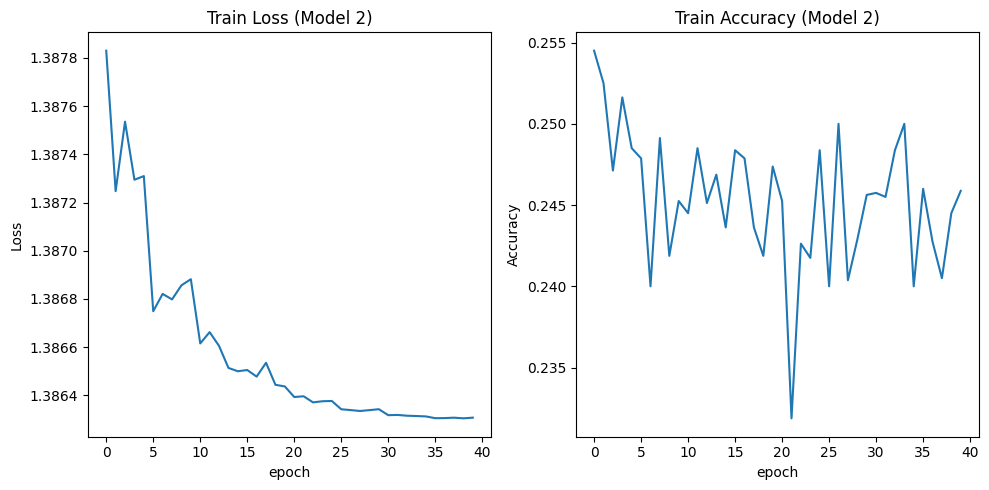

In [ ]:
# model2 loss & accuracy 그래프
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss2)
plt.title('Train Loss (Model 2)')
plt.xlabel('epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accuracy2)
plt.title('Train Accuracy (Model 2)')
plt.xlabel('epoch')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

In [ ]:
# 2번 모델 검증
test(model2,test_loader_inverted)


Test Loss: 1.3863, Test Accuracy: 0.1904


In [ ]:
# 반전 데이터 3번 모델 훈련 --LeNetCustom
train_loss3=[]
train_accuracy3=[]
for i in range(40):
  train_loss, train_accuracy = train(model3, optimizer3, train_loader_inverted, i)
  train_loss3.append(train_loss)
  train_accuracy3.append(train_accuracy)
  lr3.step()

epoch 0) train loss : 1.3875 / train_accuracy : 0.2479
epoch 1) train loss : 1.3871 / train_accuracy : 0.2494
epoch 2) train loss : 1.3872 / train_accuracy : 0.2514
epoch 3) train loss : 1.3871 / train_accuracy : 0.2470
epoch 4) train loss : 1.3873 / train_accuracy : 0.2427
epoch 5) train loss : 1.3868 / train_accuracy : 0.2417
epoch 6) train loss : 1.3867 / train_accuracy : 0.2474
epoch 7) train loss : 1.3867 / train_accuracy : 0.2521
epoch 8) train loss : 1.3868 / train_accuracy : 0.2497
epoch 9) train loss : 1.3868 / train_accuracy : 0.2469
epoch 10) train loss : 1.3866 / train_accuracy : 0.2485
epoch 11) train loss : 1.3866 / train_accuracy : 0.2387
epoch 12) train loss : 1.3867 / train_accuracy : 0.2391
epoch 13) train loss : 1.3865 / train_accuracy : 0.2506
epoch 14) train loss : 1.3866 / train_accuracy : 0.2456
epoch 15) train loss : 1.3864 / train_accuracy : 0.2424
epoch 16) train loss : 1.3864 / train_accuracy : 0.2461
epoch 17) train loss : 1.3865 / train_accuracy : 0.2445
ep

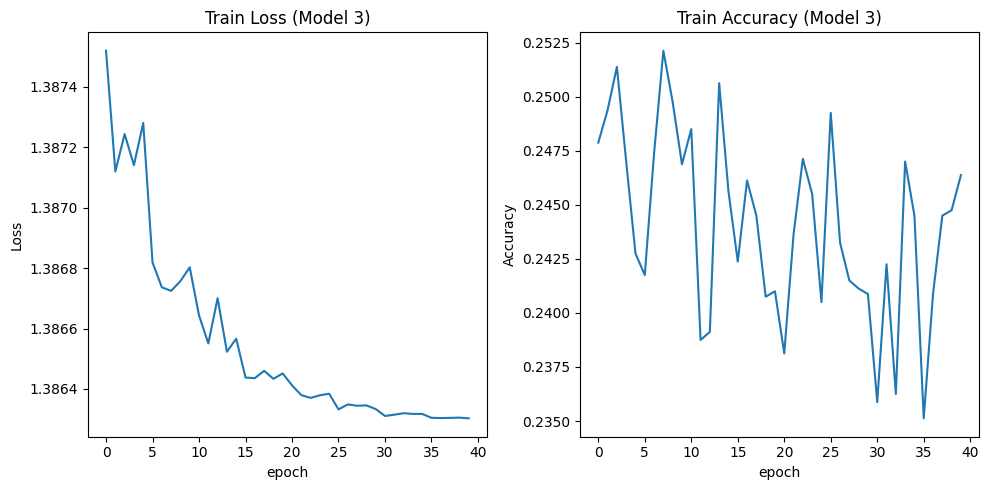

In [ ]:
# model3 loss & accuracy 그래프
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss3)
plt.title('Train Loss (Model 3)')
plt.xlabel('epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accuracy3)
plt.title('Train Accuracy (Model 3)')
plt.xlabel('epoch')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

In [ ]:
# 3번 모델 검증
test(model3,test_loader_inverted)


Test Loss: 1.3863, Test Accuracy: 0.1904
